In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from utils.plot import plot_losses, plot_train_val_evaluators
from PIL import Image
from models.load import get_model_label, get_model_name, get_current_epoch, get_dataset_label, get_trained_model
from tqdm import tqdm

from data.constants import  DEFAULT_REFLACX_LABEL_COLS
from data.paths import XAMI_MIMIC_PATH

import utils.print as print_f
from utils.init import reproducibility, clean_memory_get_device

# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):
    # CXR_images="val_ar_0_0487_ap_0_0112_test_ar_0_0494_ap_0_0124_epoch100_11-07-2022 19-23-44_All_label_testing"    
    CXR_image_5_labels = "val_ar_0_5178_ap_0_2403_test_ar_0_5277_ap_0_2606_epoch50_11-17-2022 08-48-30_label_testing"
    # 
    # CXR_images_pupil="val_ar_0_3786_ap_0_1456_test_ar_0_4015_ap_0_1718_epoch26_09-19-2022 02-32-59_CXR_images_pupil"
    # CXR_images_fixations= "val_ar_0_3871_ap_0_1611_test_ar_0_3508_ap_0_1405_epoch30_09-21-2022 08-45-03_CXR_images_fixations"
    # CXR_images_resnet= "val_ar_0_6295_ap_0_2233_test_ar_0_6295_ap_0_2365_epoch13_10-05-2022 05-28-54_CXR_images_resnet"
    # CXR_images_fixations_multiply= "val_ar_0_2275_ap_0_1134_test_ar_0_2464_ap_0_1187_epoch16_10-07-2022 09-07-36_CXR_images__fixations_multiply"
    # CXR_images_1third= "val_ar_0_1143_ap_0_0292_test_ar_0_1206_ap_0_0349_epoch14_09-22-2022 16-58-38_CXR_images_fixations_1third"
    # CXR_images_fixations_mobilenet = "val_ar_0_0552_ap_0_0182_test_ar_0_0622_ap_0_0138_epoch11_10-09-2022 03-42-33_CXR_images_fixations_mobilenet"
    # CXR_images_fixations_resnet = "val_ar_0_2876_ap_0_1181_test_ar_0_3026_ap_0_1391_epoch23_10-11-2022 06-58-51_CXR_images_fixations_resnet"
    # CXR_images_pupil_multiply = "val_ar_0_3076_ap_0_1231_test_ar_0_3568_ap_0_1647_epoch9_10-16-2022 01-28-41_CXR_images_pupil_multiply"
    # CXR_images_fixations_1third_multiply = "val_ar_0_1789_ap_0_0894_test_ar_0_1432_ap_0_0704_epoch26_10-18-2022 21-24-52_CXR_images_fixations_1third_multiply"
    # CXR_images_fixations_2third_multiply = "val_ar_0_1052_ap_0_0364_test_ar_0_0927_ap_0_0367_epoch4_10-19-2022 16-24-41_CXR_images_fixations_2third_multiply"




In [4]:
naming_map = {
    TrainedModels.CXR_image_5_labels: "CXR_image_5_labels",
    # TrainedModels.CXR_images_fixations_multiply: "CXR_fixations",
    # TrainedModels.CXR_images_pupil_multiply: "CXR_pupil",
    # TrainedModels.CXR_images_fixations_1third_multiply: "CXR_fixations_1third",
    # TrainedModels.CXR_images_fixations_2third_multiply: "CXR_fixations_2third",
}


In [5]:
for select_model in tqdm([
    TrainedModels.CXR_image_5_labels,
    # TrainedModels.CXR_images_fixations_multiply,
    # TrainedModels.CXR_images_pupil_multiply,
    # TrainedModels.CXR_images_fixations_1third_multiply,
    # TrainedModels.CXR_images_fixations_2third_multiply
]):

    model, train_info, _, _ = get_trained_model(
            select_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.5,
        )

    print(train_info)

  0%|          | 0/1 [00:00<?, ?it/s]

Using pretrained backbone. mobilenet_v3
label_testing will use mask, [64] layers.


100%|██████████| 1/1 [00:03<00:00,  3.79s/it]

Using SGD as optimizer with lr=0.001
========================================For Training [label_testing]========================================
ModelSetup(name='label_testing', use_heatmaps=False, with_fixations=False, with_pupil=False, with_1st_third_fixations=False, with_2nd_third_fixations=False, with_rad_silence=False, with_rad_speaking=False, save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=True, image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, fusion_strategy='add', fusion_residule=False, gt_in_t

In [6]:
def get_thrs_evaluation_df(
    models: List[TrainedModels], dataset, disease="all", iobb_thrs=0.5, score_thrs=0.05
):
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return pd.DataFrame(
        [
            {
                "model": str(select_model).split(".")[-1],
                **all_models_eval_data[select_model.value][iobb_thrs][0],
            }
            for select_model in models
        ]
    )[["model", "ap", "ar"]]



In [7]:
# from models.load import TrainedModels
from typing import List


def plot_iou_result(
    models: List[TrainedModels],
    datasets,
    disease="all",
    figsize=(10, 10),
    include_recall=False,
    score_thrs=0.05,
):

    cm = plt.get_cmap("rainbow")
    NUM_COLORS = len(models)

    all_models_eval_data = {dataset: {} for dataset in datasets}

    for select_model in models:
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results",
                    f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset][select_model.value] = eval_data

    fig, axes = plt.subplots(
        len(datasets),
        2 if include_recall else 1,
        figsize=figsize,
        dpi=120,
        sharex=True,
        squeeze=False,
    )

    for i, dataset in enumerate(datasets):
        axes[i, 0].set_title(f"[{dataset}] - Average Precision")
        axes[i, 0].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for select_model in models:
            axes[i, 0].plot(
                all_models_eval_data[dataset][select_model.value].keys(),
                [
                    v[0]["ap"]
                    for v in all_models_eval_data[dataset][select_model.value].values()
                ],
                marker="o",
                label=get_model_name(select_model, naming_map=naming_map),
                # color="darkorange",
            )
        axes[i, 0].legend(loc="lower left")
        axes[i, 0].set_xlabel("IoBB threshold")

        if include_recall:

            axes[i, 1].set_title(f"[{dataset}] - Average Recall")
            axes[i, 1].set_prop_cycle(
                "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
            )

            for select_model in models:
                axes[i, 1].plot(
                    all_models_eval_data[dataset][select_model.value].keys(),
                    [
                        v[0]["ar"]
                        for v in all_models_eval_data[dataset][
                            select_model.value
                        ].values()
                    ],
                    marker="o",
                    label=get_model_name(select_model, naming_map=naming_map),
                    # color="darkorange",
                )

            axes[i, 1].legend(loc="lower left")
            axes[i, 1].set_xlabel("IoBB threshold")

    plt.tight_layout()
    plt.plot()
    plt.pause(0.01)

    return fig


In [8]:
def showModelOnDatasets(
    select_model, datasets, disease="all", figsize=(10, 10), include_recall=False,
    score_thrs=0.05,
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=120, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_name(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for dataset in datasets:
        axes[0].plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            axes[1].plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")
        
    plt.tight_layout()
    plt.plot()
    plt.pause(0.01)

    return fig


In [9]:
def showModelOnScoreThrs(
    select_model: TrainedModels, dataset: str, disease="all", figsize=(10, 10), include_recall=False,
    score_thresholds=[0.5, 0.3, 0.2, 0.1, 0.05],
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(score_thresholds)

    all_models_eval_data = {}
    for score_thrs in score_thresholds:
        with open(
            os.path.join(
                "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[score_thrs] = eval_data

    fig, axes = plt.subplots(
        2 if include_recall else 1, figsize=figsize, dpi=80, sharex=True, squeeze=False,
    )

    axes = axes[0]

    fig.suptitle(get_model_name(select_model, naming_map=naming_map))

    axes[0].set_title("Average Precision")
    axes[0].set_prop_cycle(
        "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
    )

    for score_thrs in score_thresholds:
        axes[0].plot(
            all_models_eval_data[score_thrs].keys(),
            [v[0]["ap"] for v in all_models_eval_data[score_thrs].values()],
            marker="o",
            label=f"score_thrs={str(score_thrs)}",
            # color="darkorange",
        )
    axes[0].legend(loc="lower left")

    if include_recall:
        axes[1].set_title("Average Recall")
        axes[1].set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for score_thrs in score_thresholds:
            axes[1].plot(
                all_models_eval_data[score_thrs].keys(),
                [v[0]["ar"] for v in all_models_eval_data[score_thrs].values()],
                marker="o",
                label=f"score_thrs={str(score_thrs)}",
                # color="darkorange",
            )

        axes[1].legend(loc="lower left")
        axes[1].set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


In [10]:
def plot_training_progress(trained_models):
    for trained_model in trained_models:
        _, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print_f.print_title("Training Info")
        print(train_info)

        plot_train_val_evaluators(
            train_ap_ars=train_info.train_ap_ars, val_ap_ars=train_info.val_ap_ars,
        )

        plot_losses(train_info.train_data, train_info.val_data)


In [11]:
from utils.train import num_params

def print_num_params(trained_models):
    for trained_model in trained_models:
        model, train_info, _ = get_trained_model(
            trained_model,
            DEFAULT_REFLACX_LABEL_COLS,
            device,
            image_size=512,
            rpn_nms_thresh=0.3,
            box_detections_per_img=10,
            box_nms_thresh=0.2,
            rpn_score_thresh=0.0,
            box_score_thresh=0.05,
        )

        print(f"| [{train_info.model_setup.name}] | #Params: [{num_params(model):,}] |")


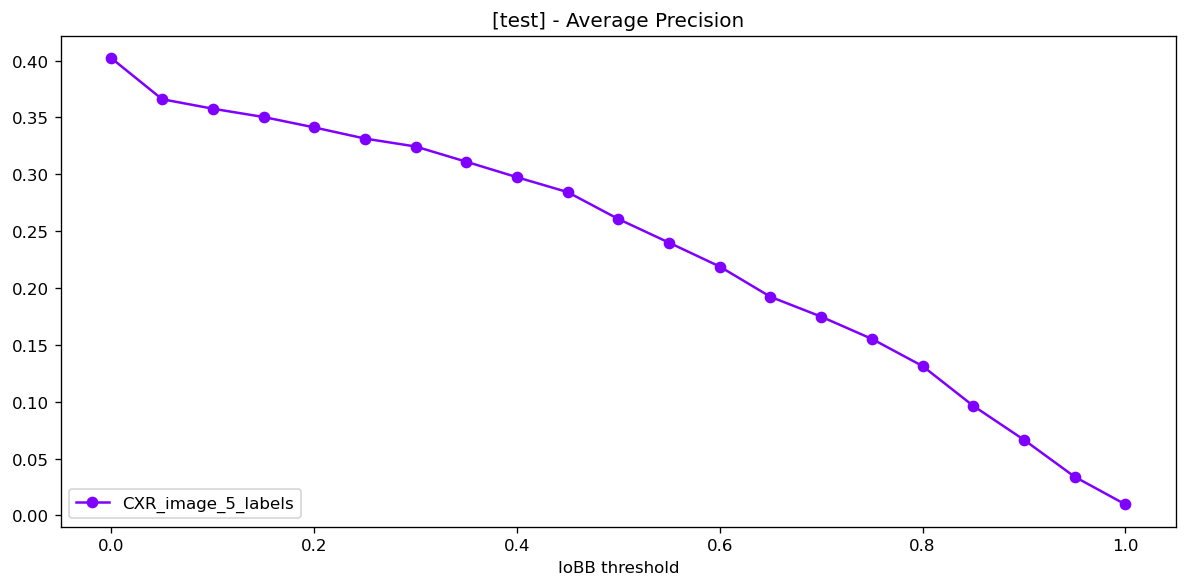

In [12]:
_ = plot_iou_result(
    [
    TrainedModels.CXR_image_5_labels,
    # TrainedModels.CXR_images_fixations_multiply,
    # TrainedModels.CXR_images_pupil_multiply,
    # TrainedModels.CXR_images_fixations_1third_multiply,
    # TrainedModels.CXR_images_fixations_2third_multiply
    ],
    ["test"], #["train", "val", "test"],
    figsize=(10, 5),
    include_recall=False,
    score_thrs=0.05,
)

In [13]:
def showModelsOnDatasets(
    select_models, datasets, disease="all", figsize=(10, 10),
    score_thrs=0.05,
):
    """
    This function used for detecting the overfitting dataset.    
    """
    cm = plt.get_cmap("gist_rainbow")
    NUM_COLORS = len(datasets)

    fig, axes = plt.subplots(
        1 , len(select_models) , figsize=figsize, dpi=120, sharex=True, sharey=True ,squeeze=False,
    )

    fig.suptitle("Average Precision")

    for c_i , select_model,in enumerate(select_models):
        all_models_eval_data = {}
        for dataset in datasets:
            with open(
                os.path.join(
                    "eval_results", f"{select_model.value}_{dataset}_{disease}_score_thrs{score_thrs}.pkl",
                ),
                "rb",
            ) as f:
                eval_data = pickle.load(f)
                all_models_eval_data[dataset] = eval_data


        ax = axes[0][c_i]

        ax.set_title(f"{get_model_name(select_model, naming_map=naming_map)}")
        ax.set_prop_cycle(
            "color", [cm(1.0 * i / NUM_COLORS) for i in range(NUM_COLORS)]
        )

        for dataset in datasets:
            ax.plot(
                all_models_eval_data[dataset].keys(),
                [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
                marker="o",
                label=dataset,
                # color="darkorange",
            )
        ax.legend(loc="lower left")
        ax.set_xlabel("IoBB threshold")
    plt.tight_layout()
    plt.plot()
    plt.pause(0.01)

    return fig


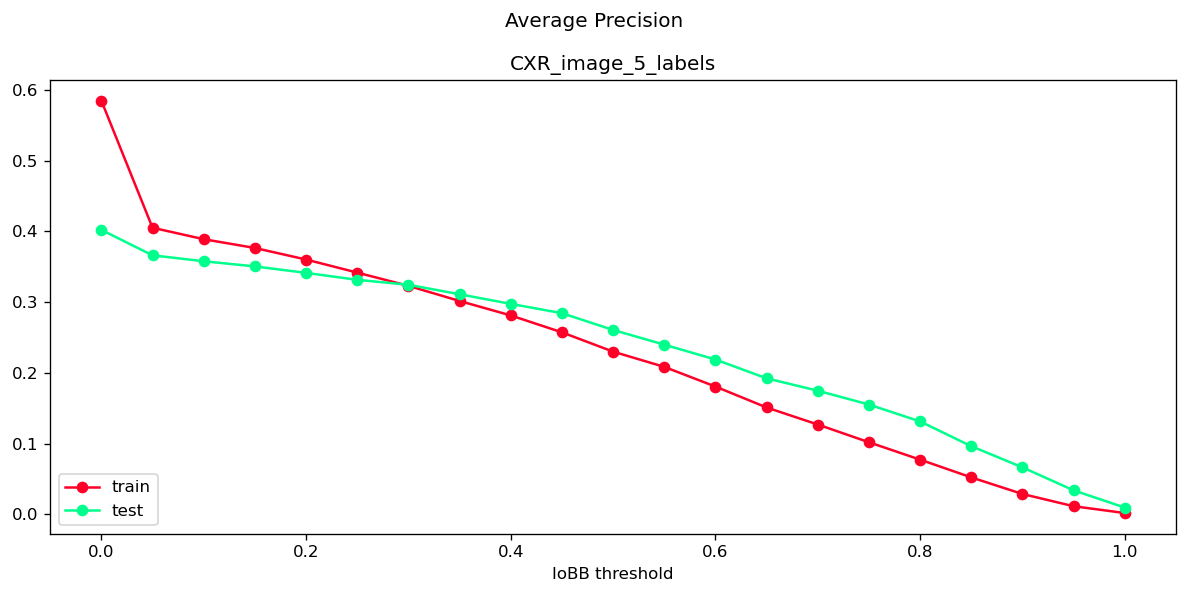

In [14]:
axes = showModelsOnDatasets(
    [    
    TrainedModels.CXR_image_5_labels,
    # TrainedModels.CXR_images_fixations_multiply,
    # TrainedModels.CXR_images_pupil_multiply,
    # TrainedModels.CXR_images_fixations_1third_multiply,
    # TrainedModels.CXR_images_fixations_2third_multiply
    ],
    ["train", "test"],  # ["train", "val", "test"]
    figsize=(10, 5),
    score_thrs=0.05,
)



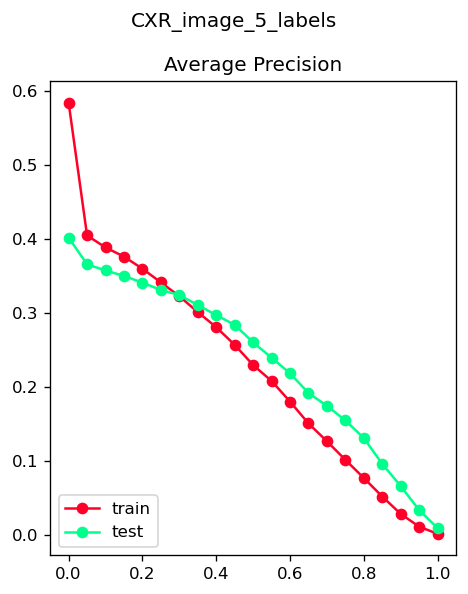

In [15]:
for model in [
    TrainedModels.CXR_image_5_labels,
    # TrainedModels.CXR_images_fixations_multiply,
    # TrainedModels.CXR_images_pupil_multiply,
    # TrainedModels.CXR_images_fixations_1third_multiply,
    # TrainedModels.CXR_images_fixations_2third_multiply
]:
    _ = showModelOnDatasets(
        model,
        ["train", "test"],  # ["train", "val", "test"]
        figsize=(4,5),
        score_thrs=0.05,
    )



In [16]:
from collections import OrderedDict


def get_mAP_mAR(
    models: List[TrainedModels],
    datasets: List[str],
    naming_map,
    score_thrs: float = 0.05,
):

    labels_cols = DEFAULT_REFLACX_LABEL_COLS + ["all"]
    # remove the labels that has "/" sign.
    labels_cols = [l.replace("/", "or") for l in labels_cols]
    # score_thrs = 0.05

    all_df = {d: {} for d in labels_cols}

    for disease_str in labels_cols:
        for select_model in models:
            model_path = select_model.value
            eval_df = pd.read_csv(
                os.path.join(
                    "eval_results",
                    f"{model_path}_{disease_str}_score_thrs{score_thrs}.csv",
                ),
                index_col=0,
            )
            all_df[disease_str][model_path] = eval_df

    # eval_dataset = 'val' # ['test', 'val', 'our']

    for eval_dataset in datasets:
        model_dfs = OrderedDict({})

        for select_model in models:
            model_path = select_model.value
            model_name = get_model_name(
                select_model, naming_map=naming_map
            )  # str(select_model).split(".")[-1]
            # Pick dataset

            model_eval = []
            for disease_str in labels_cols:
                model_eval.append(
                    {
                        **dict(
                            all_df[disease_str][model_path][
                                all_df[disease_str][model_path]["dataset"]
                                == eval_dataset
                            ].iloc[0]
                        ),
                        "disease": disease_str,
                    }
                )

            # model_dfs[model_name] = pd.DataFrame(model_eval)[
            #     ["disease", f"AP@[IoBB = 0.50:0.95]", f"AR@[IoBB = 0.50:0.95]"]
            # ]

            model_dfs[model_name] = pd.DataFrame(model_eval)[
                ["disease", f"AP@[IoBB = 0.50]", f"AR@[IoBB = 0.50]"]
            ]

        for idx, k in enumerate(model_dfs.keys()):
            if idx == 0:
                # create the merged df
                merged_df = model_dfs[k].copy()
                merged_df.columns = [
                    "disease" if c == "disease" else f"{c}_{k}"
                    for c in merged_df.columns
                ]
            else:
                df = model_dfs[k].copy()
                df.columns = [
                    "disease" if c == "disease" else f"{c}_{k}" for c in df.columns
                ]
                merged_df = merged_df.merge(df, "left", on="disease",)

        print_f.print_title(f"Dataset [{eval_dataset}]")
        display(merged_df)

        merged_df.to_csv(
            os.path.join(f"{eval_dataset}_dataset_class_ap_score_thrs_{score_thrs}.csv")
        )

        return merged_df

In [17]:
merged_df = get_mAP_mAR(
    models= [    
    TrainedModels.CXR_image_5_labels,
    # TrainedModels.CXR_images_fixations_multiply,
    # TrainedModels.CXR_images_pupil_multiply,
    # TrainedModels.CXR_images_fixations_1third_multiply,
    # TrainedModels.CXR_images_fixations_2third_multiply
    ],
    datasets= ["test"],#["train", "val", "test"],
    score_thrs= 0.05,
    naming_map=naming_map
)

====================Dataset [test]====================


,disease,AP@[IoBB = 0.50]_CXR_image_5_labels,AR@[IoBB = 0.50]_CXR_image_5_labels
0,Pulmonary edema,0.140660,0.461538
1,Enlarged cardiac silhouette,0.612069,0.780000
2,Consolidation,0.237714,0.552632
3,Atelectasis,0.105512,0.347368
4,Pleural abnormality,0.207238,0.497076
5,all,0.260639,0.527723


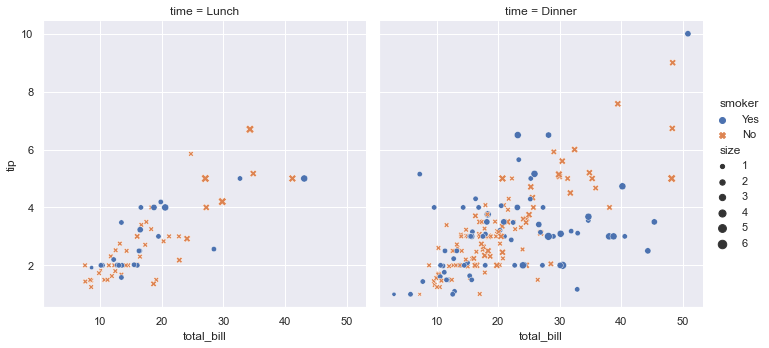

In [18]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

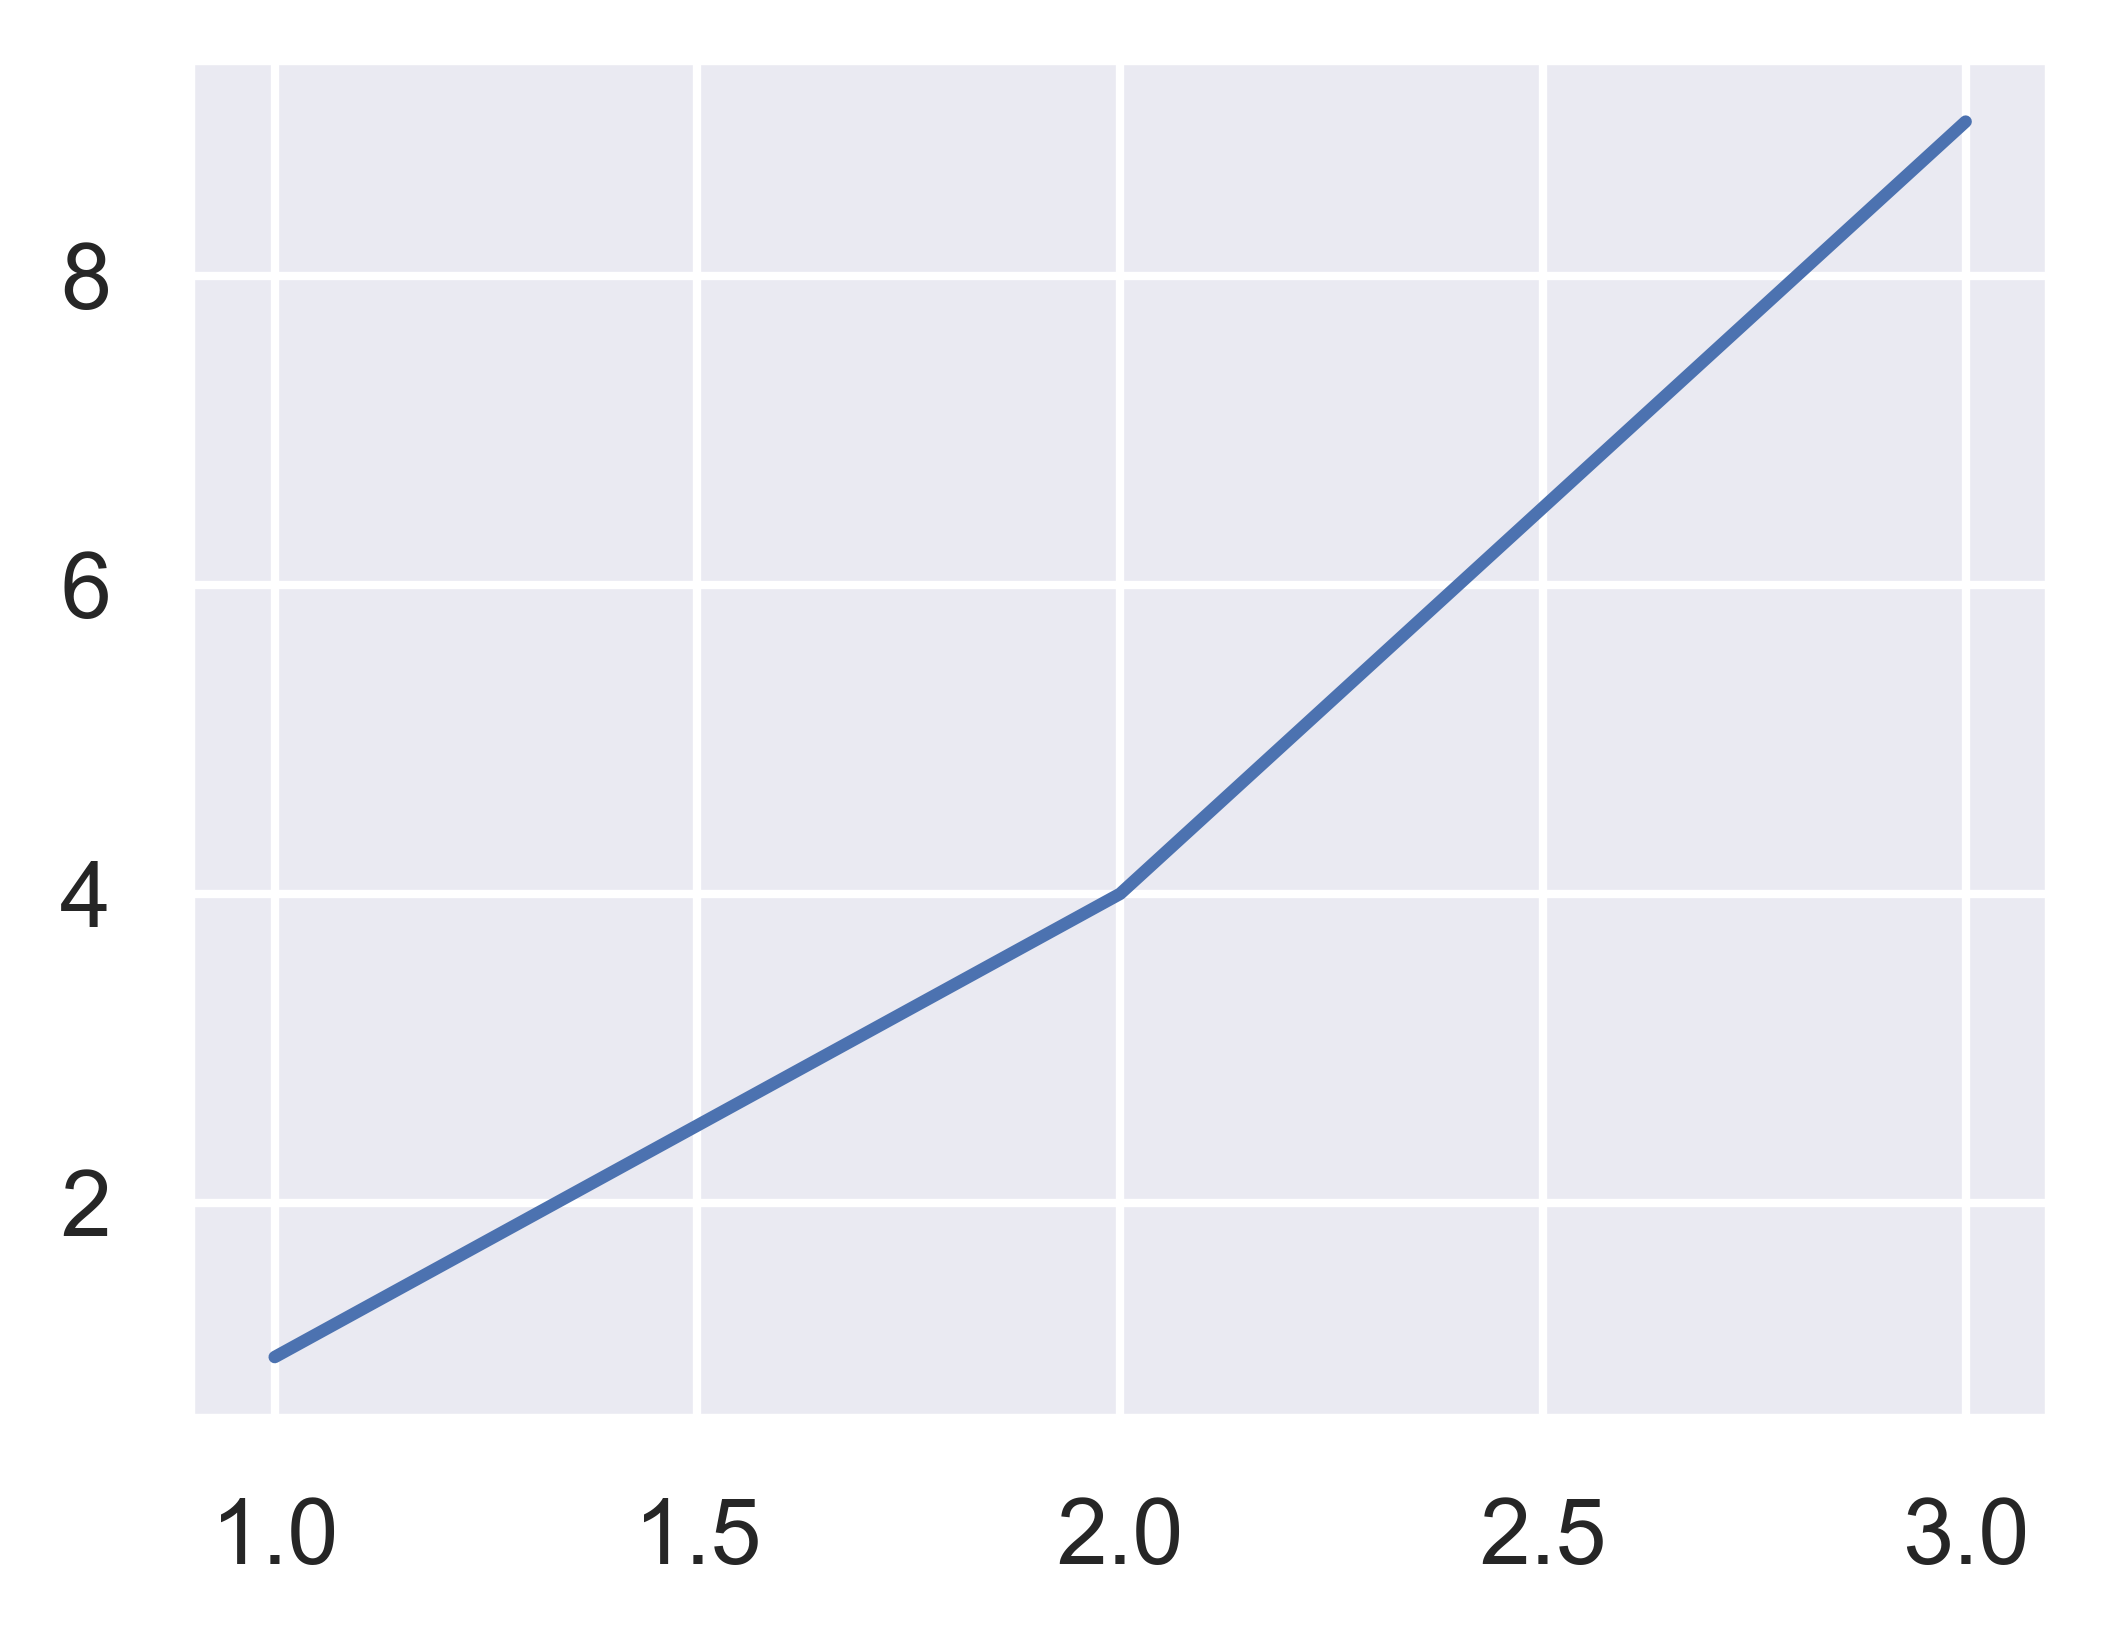

In [19]:
# test
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=600)
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()

In [20]:
for col in merged_df.columns[1:]:
    merged_df[col] = merged_df[col].apply(lambda x: f"{x*100:.4f}")

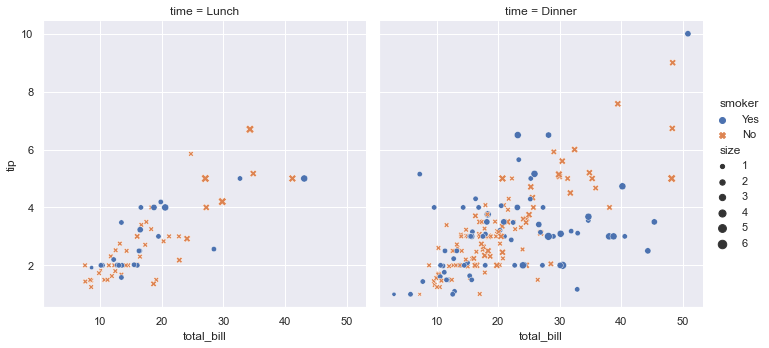

In [21]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

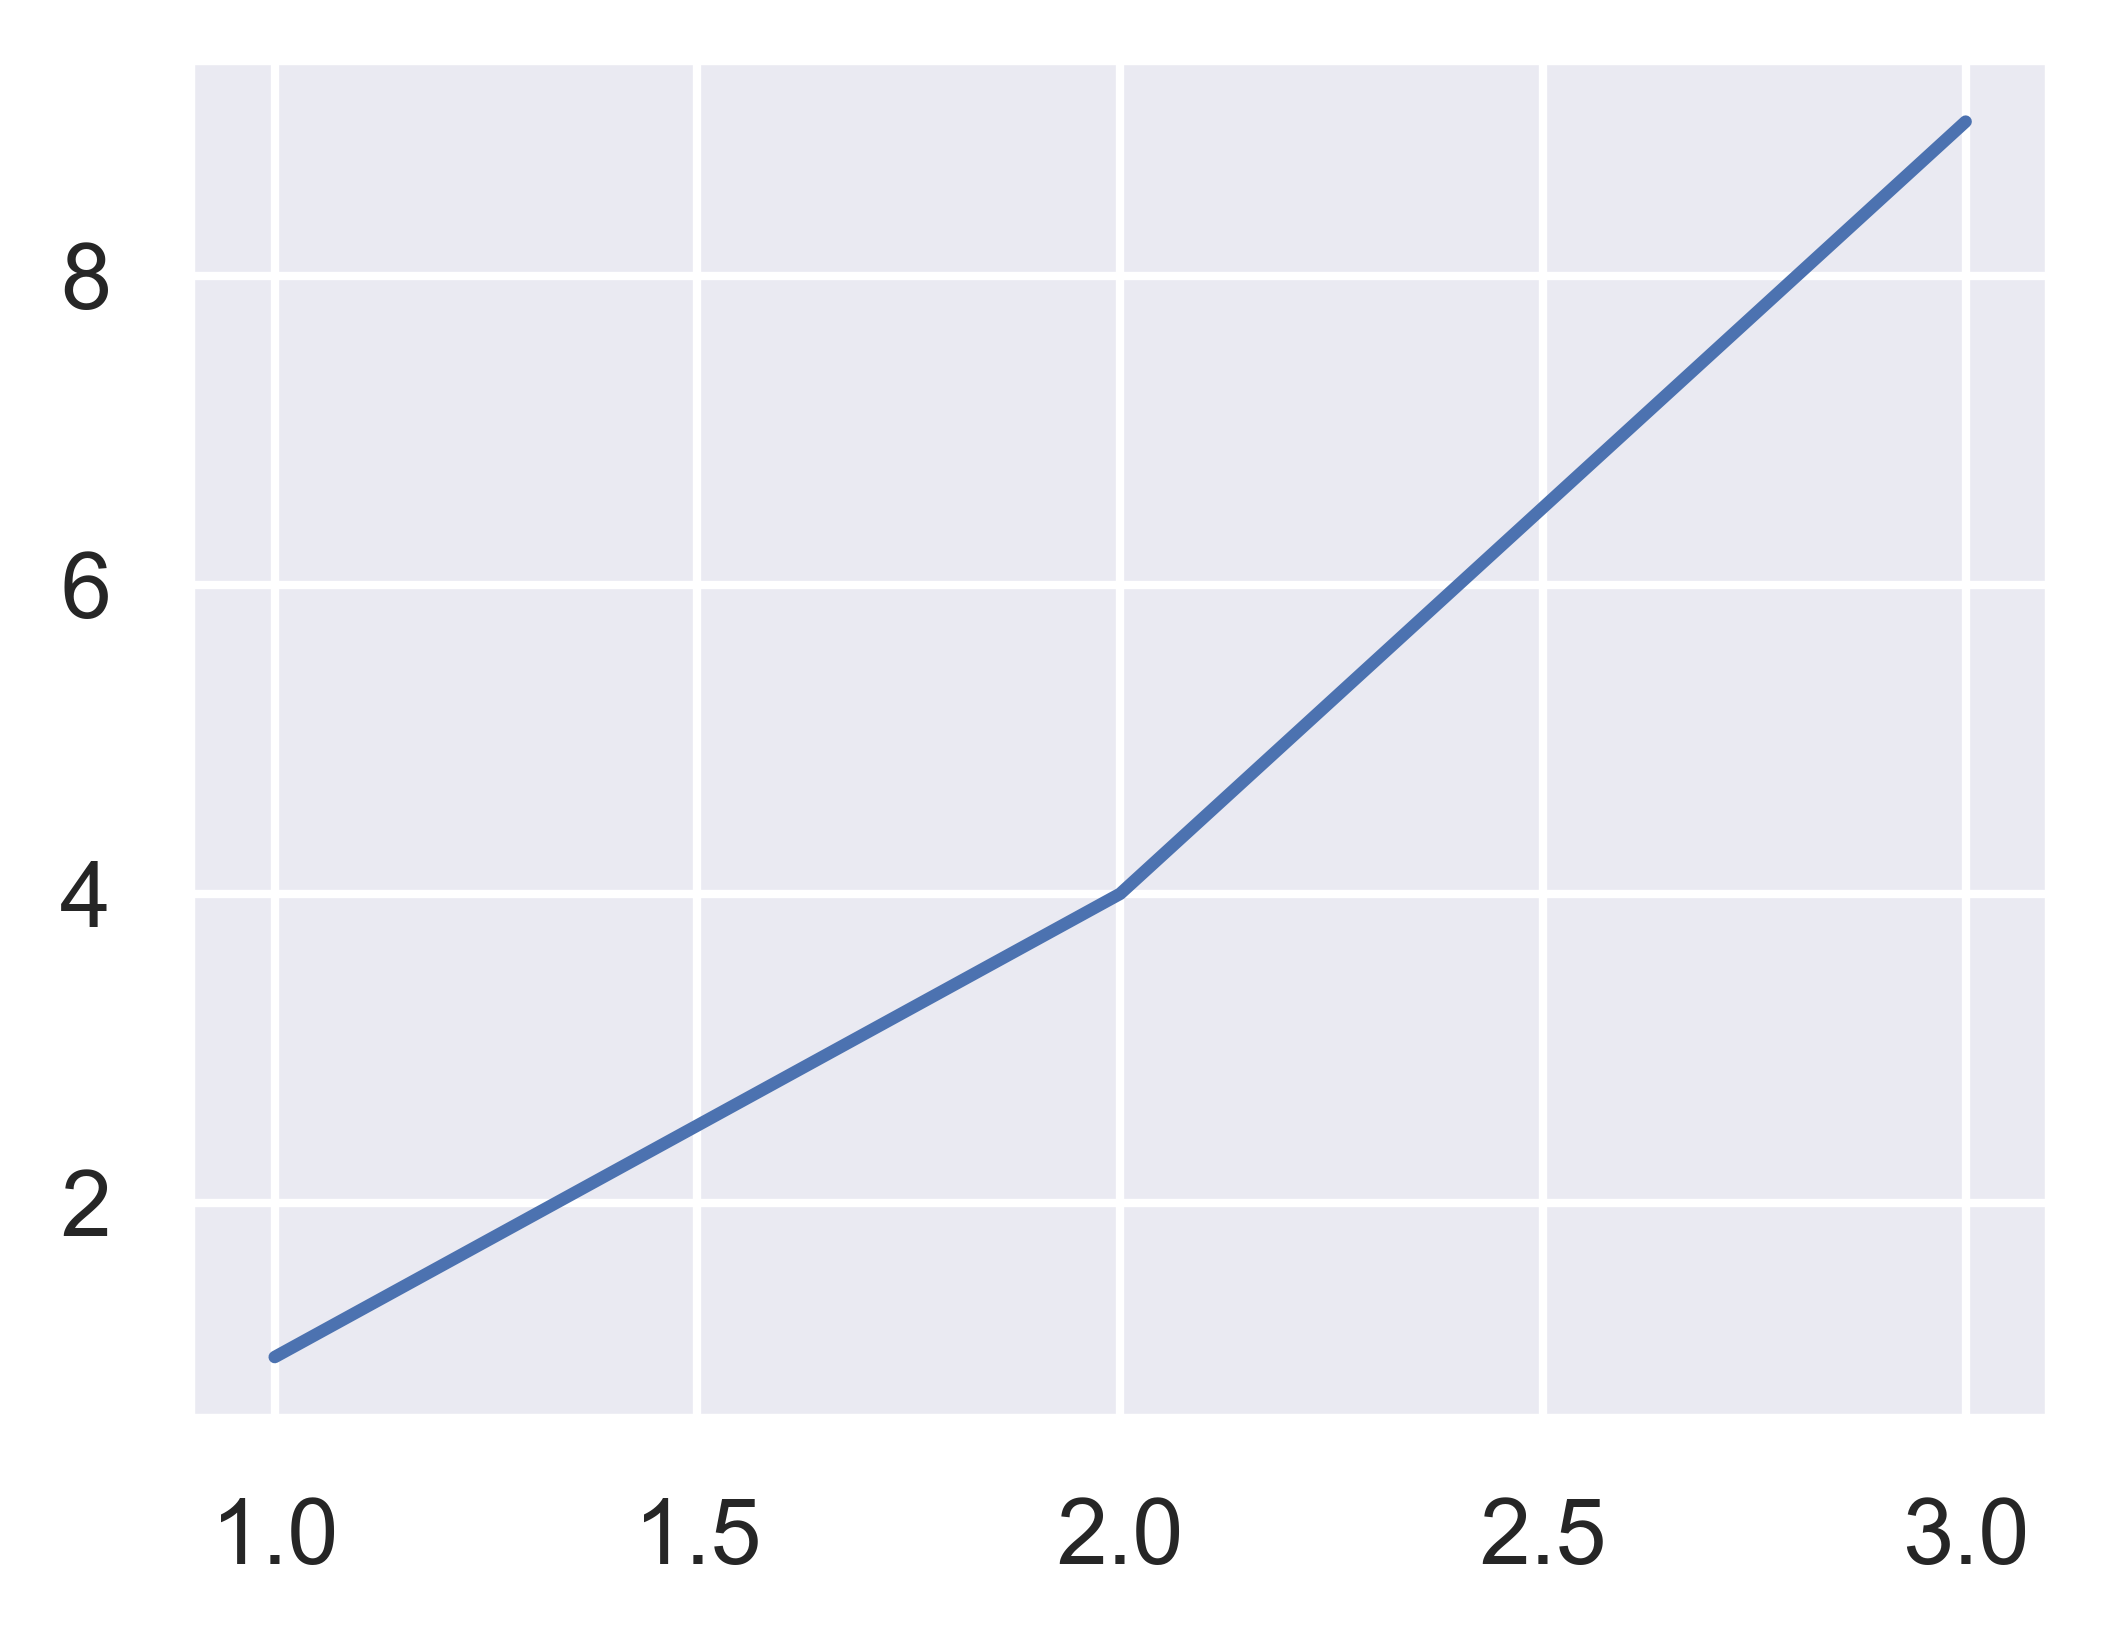

In [22]:
# test
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=600)
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()